# K-Means Clustering

Principal Component Analysis and *4.3 Clustering Analysis* in [Main Notebook](https://github.com/czarinagluna/sxsw-sentiment-analysis/blob/main/main.ipynb)
***
**By [Czarina Luna](https://czarinaluna.com)**

In [1]:
# Load processed dataset
import pandas as pd
import numpy as np

data = pd.read_csv('data/clustering/processed.csv')
data.head()

,text,product,target,processed
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,tweeting rise dead need upgrade plugin station
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,2,know awesome likely appreciate design also giv...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,2,wait also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,hope year festival crashy year
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,2,great stuff marissa mayer reilly tech book con...


In [2]:
# Create corpus of all the words
corpus = []

for sentence in data['processed'].iteritems():
    word_list = sentence[1].split(" ")
    corpus.append(word_list)

In [3]:
import warnings
warnings.filterwarnings('ignore')

Apply Principal Component Analysis to reduce dimensionality:

In [4]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

# Vectorization using Word2Vec
model = Word2Vec(corpus, size=100, min_count=1)
vectors = model[model.wv.vocab]
words = list(model.wv.vocab)

# Fit PCA to word vectors
pca = PCA(n_components=2)
PCA_result = pca.fit_transform(vectors)

**Word Vectors**

In [5]:
result = pd.DataFrame(PCA_result)

result['x_values'] = result.iloc[:, 0]
result['y_values'] = result.iloc[:, 1]

In [6]:
PCA_data = pd.merge(pd.DataFrame(words), result, left_index=True, right_index=True)

PCA_data['word'] = PCA_data.iloc[:, 0]
PCA_data = PCA_data[['word','x_values','y_values']]
PCA_data.to_csv('data/clustering/PCA_data.csv',index=False)

Top 100 Words:

In [7]:
from collections import Counter

count = Counter()
for text in data['processed'].values:
    for word in text.split():
        count[word] += 1
        
def top(n, filename):
    '''
    Write here.
    '''
    top = count.most_common(n)
    top = pd.DataFrame(top)
    
    top['word'] = top.iloc[:, 0]
    top['count'] = top.iloc[:, 1]
    
    df = PCA_data.merge(top[['word', 'count']], how='inner', left_on='word',right_on='word')
    df.to_csv(f'data/clustering/{filename}.csv', index=False)

In [8]:
top(100, 'PCA_top100')

Top 1000 Words:

In [9]:
top(1000, 'PCA_top1000')

**Clustering using [Orange](https://orangedatamining.com/)**

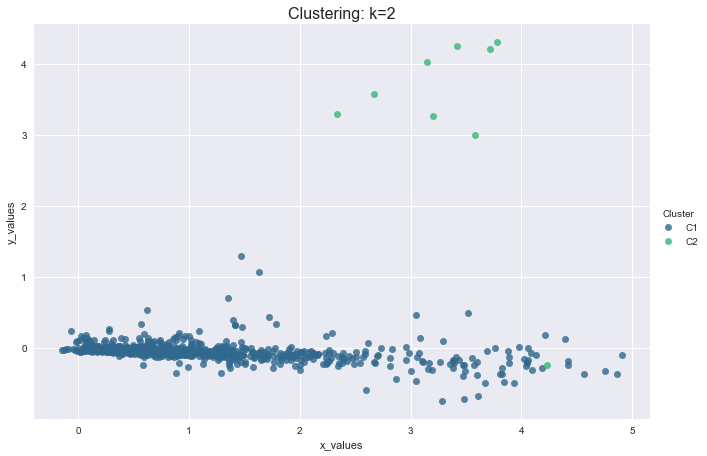

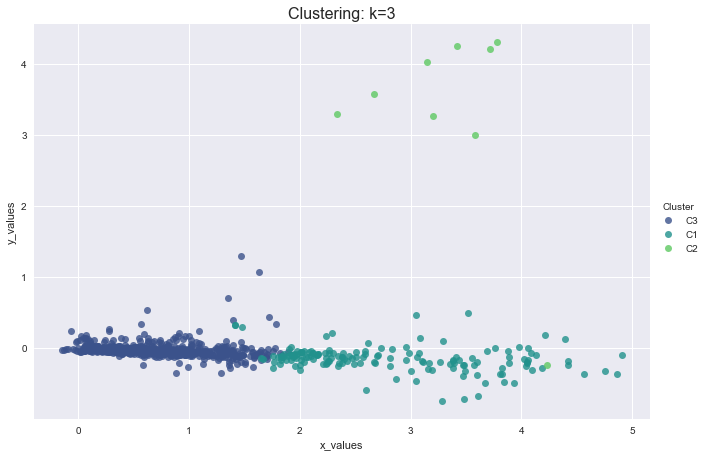

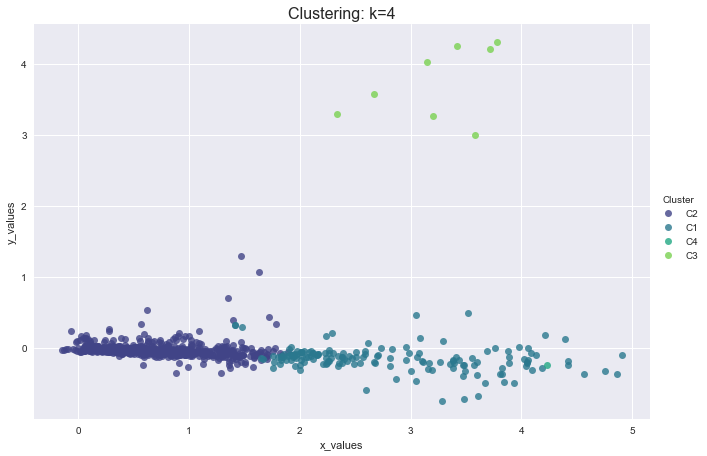

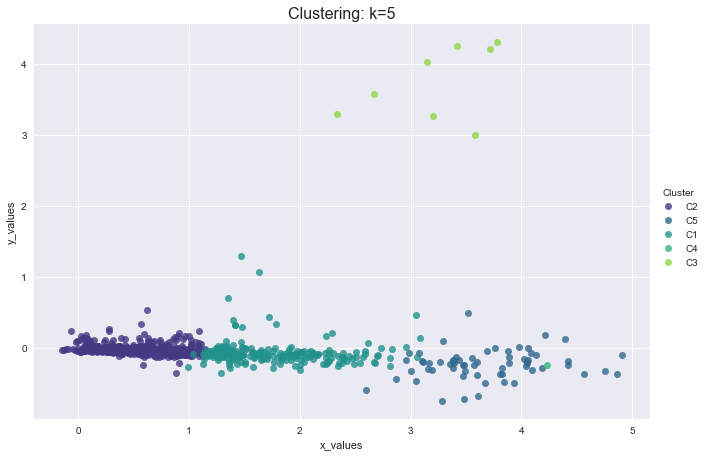

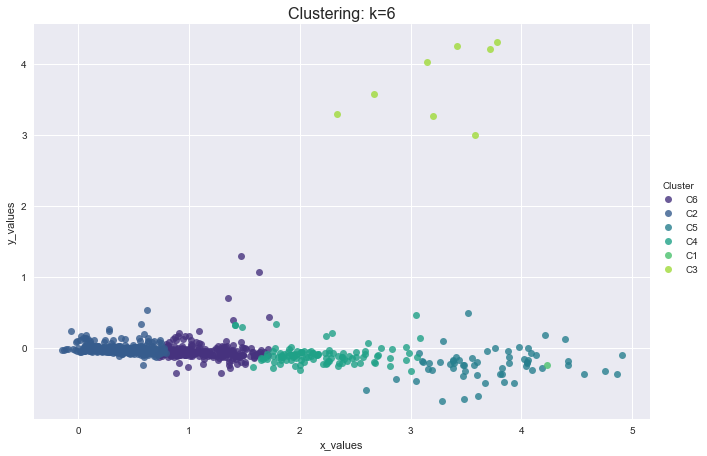

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')

def plot(cluster):
    '''
    Plots data points by cluster.
    '''
    df = pd.read_csv(f'data/clustering/{cluster}.csv').drop([0,1]).reset_index(drop=True)
    columns = ['x_values', 'y_values', 'count', 'Silhouette']
    df[columns] = df.loc[:, columns].astype('float64')
    
    sns.lmplot(x='x_values', y='y_values', data=df, fit_reg=False, legend=True, hue='Cluster', palette='viridis', height=6, aspect=1.5)
    plt.gcf()
    
    plt.title(f'Clustering: {cluster}', fontsize=16)
    plt.savefig(f'data/images/{cluster}.png', dpi=200, transparent=True, bbox_inches='tight') 
    plt.show()

# Plot clusters at k=2 to k=6
for i in range(2,7):
    plot(f'k={i}')
    print('\n')

**Word Clouds**

In [11]:
from wordcloud import WordCloud

def wordcloud(name, cluster, bg_color=None, colormap='viridis'):
    '''
    Generates wordcloud and saves image to file.
    '''
    plt.figure(figsize=(8,5))
    plt.title(f'{name}', fontsize=16, pad=20)
    
    cloud = WordCloud(min_font_size=20, prefer_horizontal=1, max_words=50, random_state=1,
                      background_color='rgba(255,255,255,0)', mode='RGBA', colormap=colormap, 
                      width=800, height=400).generate_from_frequencies(dict(cluster))
    plt.imshow(cloud)
    plt.axis('off')
    
    plt.savefig(f'data/images/{name}.png', dpi=200, transparent=True)
    plt.show()

In [12]:
cluster_data = pd.read_csv(f'data/clustering/k=6.csv').drop([0,1]).reset_index(drop=True)
columns = ['x_values', 'y_values', 'count', 'Silhouette']
cluster_data[columns] = cluster_data.loc[:, columns].astype('float64')

clusters = {}

for i in range(1,7):
    clusters[f'Cluster {i}'] = cluster_data.loc[cluster_data['Cluster']==f'C{i}']

In [13]:
%store cluster_data

Stored 'cluster_data' (DataFrame)


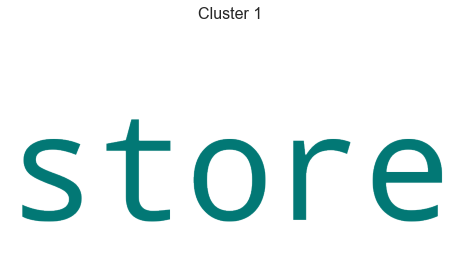

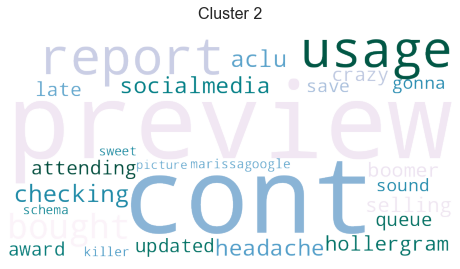

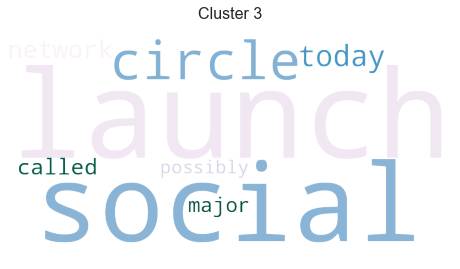

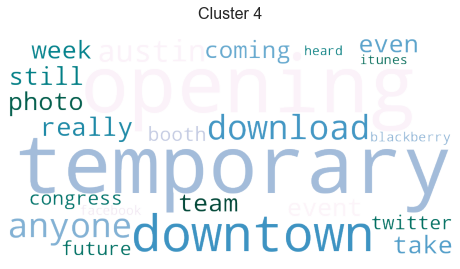

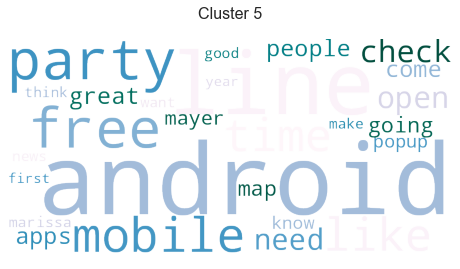

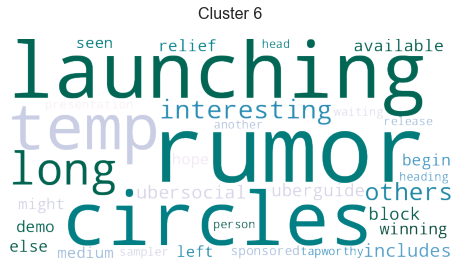

In [14]:
# Create word cloud per cluster
for key, val in clusters.items():
    count = val[['word', 'count']].sort_values('count', ascending=False).reset_index(drop=True)
    
    frequency = []
    for i in range(len(count)):
        frequency.append((count.loc[i, 'word'], count.loc[i, 'count']))

    wordcloud(key, frequency, colormap='PuBuGn')
    print('\n')

Silhouette scores:

In [15]:
cluster_data.groupby('Cluster').agg(['count', 'mean'])['Silhouette']

,count,mean
Cluster,,
C1,1,0.500000
C2,544,0.671562
C3,8,0.694157
C4,112,0.621268
C5,60,0.598980
C6,275,0.598727


In [16]:
cluster_data.sort_values('count', ascending=False)[:20]

,x_values,y_values,count,word,Cluster,Silhouette
71,4.232746,-0.236558,1528.0,store,C1,0.500000
122,3.200685,3.263005,683.0,launch,C3,0.688537
124,3.783673,4.306313,663.0,social,C3,0.702629
36,4.860034,-0.365946,598.0,android,C5,0.577045
127,3.717602,4.206253,587.0,circle,C3,0.709477
129,3.582466,3.000314,577.0,today,C3,0.684160
125,3.420786,4.252448,467.0,network,C3,0.710541
131,3.671145,-0.488340,448.0,line,C5,0.593595
55,4.751184,-0.324246,401.0,party,C5,0.613791
12,4.564972,-0.364521,388.0,free,C5,0.616656


# Contact

Feel free to contact me for any questions and connect with me on [Linkedin](https://www.linkedin.com/in/czarinagluna/).